# Fake News Classifer

Projet de l'ue ML1 du groupe composé de : 
* Alexandre Cauty
* Thomas Juliat
* Loic Schnuriger
* Lucas Aissaoui

In [78]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
import base64
import sys

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns

# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize 



nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juliatthomas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliatthomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juliatthomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Connection à Google Drive

In [79]:
from MyNLPUtilities import *

# Importer les données

Cette cellule contient permet d'importer les données depuis le fichier csv, on utilise "news400rows.csv" pour les test et "news.csv" contient l'intégralité des données

In [80]:
news = pd.read_csv("news8904.csv", sep=",")

X = news.drop(['ratingName', 'Unnamed: 0', 'language', 'truthRating', 'id'], axis=1)

display(X.head())

Y = pd.DataFrame(news['ratingName'])
# Conversion de True/False en 0/1
Y = Y['ratingName'].astype(int)

X = X.to_numpy()
Y = Y.to_numpy()

,text,date,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link
0,'Liberals' want to change the name of Cracker ...,Unknown,Unknown,Liberals Want to Change the Name of ‘Cracker B...,"Change.org,Charleston, South Carolina,Cracker ...",NaN,"caucasian barrel, change.org, cracker barrel, ...",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/caucasian-ba...
1,U.S. President Donald Trump laughed during a r...,Unknown,Unknown,Did Trump Laugh When Audience Member at Rally ...,"Donald Trump,El Paso, Texas,Hispanic,Latino,Pa...",Donald Trump,NaN,snopes,http://www.snopes.com,https://www.snopes.com/fact-check/trump-laugh-...
2,'Californians are overwhelmingly against this ...,2018-02-01,Travis Allen,"Travis Allen gets it wrong, again, on support ...","Capital Public Radio,Fox News,Los Angeles Time...",NaN,"Crime,Criminal Justice,Immigration,Polls and P...",politifact,http://www.politifact.com,http://www.politifact.com/california/statement...
3,"'At least Obama didn't marry his cousin,' as G...",2007-07-19,Obama Girl,Giuliani's first wife was his second cousin,"Amber Lee Ettinger,Barack Obama,Barelypolitica...",NaN,Candidate Biography,politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...
4,Says 'Obama paid FBI informant over $1 million...,2018-05-22,Bloggers,Online story gets details wrong about informan...,"Carter Page,Donald Trump,FBI,Facebook,George P...",FBI,"Elections,Fake news",politifact,http://www.politifact.com,http://www.politifact.com/punditfact/statement...


In [81]:
import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

def MyCleanText(X, 
               lowercase=False, # mettre en minuscule
               removestopwords=False, # supprimer les stopwords
               removedigit=False, # supprimer les nombres  
               getstemmer=False, # conserver la racine des termes
               getlemmatisation=False # lematisation des termes 
              ):

    sentence=str(X)

    # suppression des caractères spéciaux
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    # suppression de tous les caractères uniques
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    # substitution des espaces multiples par un seul espace
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    sentence = str(sentence).lower()
    sentence = re.sub('\[.*?\]', '', sentence)
    sentence = re.sub('https?://\S+|www\.\S+', '', sentence)
    sentence = re.sub('<.*?>+', '', sentence)
    sentence = re.sub('[%s]' % re.escape(string.punctuation), '', sentence)
    sentence = re.sub('\n', '', sentence)
    sentence = re.sub('\w*\d\w*', '', sentence)

    # decoupage en mots
    tokens = word_tokenize(sentence)
    if lowercase:
          tokens = [token.lower() for token in tokens]

    # suppression ponctuation
    table = str.maketrans('', '', string.punctuation)
    words = [token.translate(table) for token in tokens]

    # suppression des tokens non alphabetique ou numerique
    words = [word for word in words if word.isalnum()]

    # suppression des tokens numerique
    if removedigit:
        words = [word for word in words if not word.isdigit()]

    # suppression des stopwords
    if removestopwords:
        words = [word for word in words if not word in stop_words]

    # lemmatisation
    if getlemmatisation:
        lemmatizer=WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word)for word in words]

    # racinisation
    if getstemmer:
        ps = PorterStemmer()
        words=[ps.stem(word) for word in words]

    sentence= ' '.join(words)
    #print(sentence)
  
    return sentence

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juliatthomas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliatthomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juliatthomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Normaliseur de text

In [82]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 removestopwords=False, # suppression des stopwords
                 lowercase=False,# passage en minuscule
                 removedigit=False, # supprimer les nombres  
                 getstemmer=False,# racinisation des termes 
                 getlemmatisation=False # lemmatisation des termes  
                ):
        
        self.lowercase=lowercase
        self.getstemmer=getstemmer
        self.removestopwords=removestopwords
        self.getlemmatisation=getlemmatisation
        self.removedigit=removedigit

    def transform(self, X, **transform_params):
        # Nettoyage du texte
        X=X.copy() # pour conserver le fichier d'origine

        return [MyCleanText(text,lowercase=self.lowercase,
                            getstemmer=self.getstemmer,
                            removestopwords=self.removestopwords,
                            getlemmatisation=self.getlemmatisation,
                            removedigit=self.removedigit) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)

    def get_params(self, deep=True):
        return {
            'removestopwords':self.removestopwords,
            'lowercase':self.lowercase,
            'removedigit':self.removedigit,
            'getstemmer':self.getstemmer,
            'getlemmatisation':self.getlemmatisation
        }
    
    def set_params (self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter,value)
        return self

In [83]:
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# TEST DES HYPERPARAMETRE

Application de gridsearch ...
pipeline : ['cleaner', 'count_vectorizer', 'classifier']
parameters :
{'classifier__min_samples_split': [2, 3, 4, 5], 'classifier__max_features': ['auto', 'sqrt', 'log2'], 'classifier__oob_score': [True, False], 'classifier__n_jobs': [1, 4, -1], 'classifier__warm_start': [True, False]}
Fitting 5 folds for each of 144 candidates, totalling 720 fits
réalisé en  4518.982 s
Meilleur résultat : 0.712
Accuracy : 0.715
Classification Report
              precision    recall  f1-score   support

           0    0.72464   0.68182   0.70258       440
           1    0.70650   0.74723   0.72629       451

    accuracy                        0.71493       891
   macro avg    0.71557   0.71452   0.71443       891
weighted avg    0.71546   0.71493   0.71458       891



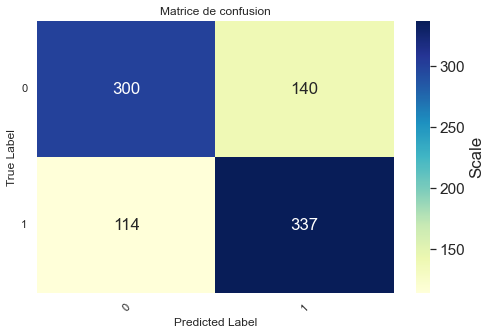

Ensemble des meilleurs paramètres :
	classifier__max_features: 'sqrt'
	classifier__min_samples_split: 4
	classifier__n_jobs: 1
	classifier__oob_score: False
	classifier__warm_start: True

Les premiers résultats : 
    classifier__max_features  classifier__min_samples_split  \
74                     sqrt                              4   
44                     auto                              5   
18                     auto                              3   
91                     sqrt                              5   
54                     sqrt                              2   

    classifier__n_jobs  classifier__oob_score  classifier__warm_start  \
74                   1                  False                    True   
44                  -1                   True                    True   
18                   4                  False                    True   
91                   4                  False                   False   
54                   4                  False  

In [84]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)


pipeline = Pipeline([("cleaner", TextNormalizer(True,True,False,True,True)), ("count_vectorizer", CountVectorizer()),
                     ("classifier",RandomForestClassifier(criterion="entropy", n_estimators=100))])

# creation des différents paramètres à tester pour SVM
# Attention dans le pipeline le nom pour le classifier SVM est : svm même si l'algorithme s'appelle SVC
# pour le référencer il faut utiliser le nom utilisé, i.e. svm, puis deux caractères soulignés
# et enfin le nom du paramètre
parameters = {
    'classifier__min_samples_split': [2,3,4,5],
    'classifier__max_features' : ['auto', 'sqrt', 'log2'],
    'classifier__oob_score' : [True, False],
    'classifier__n_jobs' : [1,4,-1],
    'classifier__warm_start' : [True, False]
}


score='accuracy'

# Application de gridsearchcv, n_jobs=-1 permet de pouvoir utiliser plusieurs CPU s'ils sont disponibles
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,scoring=score)

print("Application de gridsearch ...")
print("pipeline :", [name for name, _ in pipeline.steps])
print("parameters :")
print(parameters)
start_time = time.time()
grid_search.fit(X_train, y_train)
print("réalisé en  %0.3f s" % (time.time() - start_time))
print("Meilleur résultat : %0.3f" % grid_search.best_score_)

# autres mesures et matrice de confusion
y_pred = grid_search.predict(X_test)
MyshowAllScores(y_test,y_pred)


print("Ensemble des meilleurs paramètres :")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

# Affichage des premiers résultats du gridsearch
df_results=pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),
                      pd.DataFrame(grid_search.cv_results_["mean_test_score"],
                                   columns=[score])],axis=1).sort_values(score,ascending=False)
print ("\nLes premiers résultats : \n",df_results.head())




# LE TEST

In [85]:
pipeOpti = Pipeline([("cleaner", TextNormalizer(True,True,False,True,True)), ("count_vectorizer", CountVectorizer()),
                     ("classifier",RandomForestClassifier(criterion="entropy",
                                                          max_features="log2",
                                                          min_samples_split=4,
                                                          n_jobs=1,
                                                          oob_score=False,
                                                          warm_start=False))])

seed=7
k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
scoring = 'accuracy'
score = cross_val_score(pipeOpti, X, Y, cv=k_fold, scoring=scoring)

print('Les différentes accuracy pour les 10 évaluations sont : \n',
      score,'\n')
print ('Accuracy moyenne : %0.3f'%(score.mean()),
       ' standard deviation %0.3f'%(score.std()))



Les différentes accuracy pour les 10 évaluations sont : 
 [0.7037037  0.71268238 0.70145903 0.6969697  0.71011236 0.69550562
 0.69325843 0.69662921 0.69775281 0.71123596] 

Accuracy moyenne : 0.702  standard deviation 0.007


# Visualisation de données

In [86]:
!pip3 install plotly

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [87]:
from sklearn.decomposition import PCA
import plotly.express as px

In [88]:
news = pd.read_csv("news400rows.csv", sep=",")

X = news.drop(['ratingName'], axis=1)
Y = pd.DataFrame(news['ratingName'])

# Conversion de True/False en 0/1
Y = Y['ratingName'].astype(int)

In [89]:
texte = news['text']

print ("Application de TfidfVectorizer :")
vectorizer = TfidfVectorizer()
# fit et transform en une opération
X = vectorizer.fit_transform(texte)

# creation du dataframe pour affichage
df = pd.DataFrame(
    data=vectorizer.transform(texte).toarray(),
    columns=vectorizer.get_feature_names()
)

#display(df)
X = df



Application de TfidfVectorizer :


In [90]:
!pip3 install umap-learn


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [91]:
!pip3 install numba==0.54


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [92]:
from sklearn.manifold import TSNE
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



import umap



In [93]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)
fig = px.scatter(components, x=0, y=1,color=Y)
fig.show()


test = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
fig = px.scatter(test, x=0, y=1,color=Y)
fig.show()

